In [2]:
"""This notebook contains the code for best subset selection, 
so this notebook may take longer time to run, for faster run, make
max_feature into a smaller number"""
max_feature = 3
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd 
import math
import time
import random
import itertools

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler 
from sklearn import linear_model 
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
Hitters = pd.read_csv('/Users/shilpa/Documents/blog/Sharing_ISL_python/data/Hitters.csv', header=0, na_values='NA')

print(list(Hitters)) # get the header of this data

print(Hitters.shape) # get the dimension of this 

Hitters.head() # pull a sample of this dataset

['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague']
(322, 20)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [4]:
print(np.sum(pd.isnull(Hitters['Salary']))) # number of NAs in Salary column'
print(Hitters['Salary'].isnull().sum())

Hitters = Hitters.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
Hitters.shape
    
print(Hitters['Salary'].isnull().sum())

59
59
0


In [5]:
y = Hitters.Salary  # the response variable 

"""
take care of the features 
1. change category into dummy variables 
2. Choose (n-1) dummy variable into the feature set: n is the unique values of each categorical variable.
"""

dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])

X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)
X

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_A,Division_E,NewLeague_A
0,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,0,0,0
1,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,1,0,1
2,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,0,1,0
3,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,0,1,0
4,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,497.0,127.0,7.0,65.0,48.0,37.0,5.0,2703.0,806.0,32.0,379.0,311.0,138.0,325.0,9.0,3.0,0,1,0
259,492.0,136.0,5.0,76.0,50.0,94.0,12.0,5511.0,1511.0,39.0,897.0,451.0,875.0,313.0,381.0,20.0,1,1,1
260,475.0,126.0,3.0,61.0,43.0,52.0,6.0,1700.0,433.0,7.0,217.0,93.0,146.0,37.0,113.0,7.0,1,0,1
261,573.0,144.0,9.0,85.0,60.0,78.0,8.0,3198.0,857.0,97.0,470.0,420.0,332.0,1314.0,131.0,12.0,1,1,1


In [6]:
"""
Since in Python there is no well-defined function for best subset selection, 
we will need to define some functions ourselves.
1. Define a function to run on a subset of feature and extract RSS
2. Select the best model (models) for a fix number of features
"""
def getRSS(y, X, feature_list):
    model = sm.OLS(y, X[list(feature_list)]).fit()
    RSS = ((model.predict(X[list(feature_list)]) - y) ** 2).sum()
    return {'Model':model, "RSS":RSS}

def bestModel(y, X, K):
    results = []
    for c in itertools.combinations(X.columns, K):
        results.append(getRSS(y, X, c))     
    model_all =  pd.DataFrame(results)
    
    best_model = model_all.loc[model_all["RSS"].idxmin()] ## this could be modified to have the top several models
    return best_model

In [8]:
models = pd.DataFrame(columns=["RSS", "Model"])
for i in range(1,(max_feature+1)):  # for illustration purpuse, I just run for 1 - max_fearure features 
    models.loc[i] = bestModel(y, X, i)
    
print(models.loc[2, 'Model'].summary())
print(models)
# this summay confirms that the best two variable model contains the variables Hits and CRBI

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              416.7
Date:                Sat, 12 Sep 2020   Prob (F-statistic):                    5.80e-82
Time:                        22:16:21   Log-Likelihood:                         -1907.6
No. Observations:                 263   AIC:                                      3819.
Df Residuals:                     261   BIC:                                      3826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

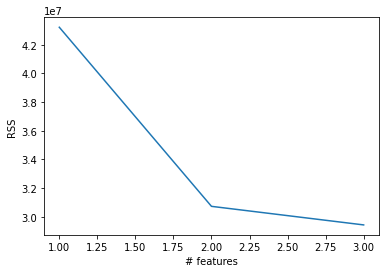

In [9]:
""" this show an example to plot the RSS of best models with different number of parameters"""
plt.figure()
plt.plot(models["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

In [10]:
dir()

['Hitters',
 'In',
 'Out',
 'PCA',
 'PLSRegression',
 'PLSSVD',
 'StandardScaler',
 'X',
 'X_prep',
 '_',
 '_1',
 '_3',
 '_5',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i2',
 '_i3',
 '_i4',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'abline_plot',
 'add_lowess',
 'added_variable_resids',
 'bestModel',
 'ceres_resids',
 'cross_val_predict',
 'datasets',
 'dummies',
 'exit',
 'getRSS',
 'get_ipython',
 'i',
 'influence_plot',
 'itertools',
 'linear_model',
 'math',
 'max_feature',
 'mean_squared_error',
 'models',
 'np',
 'partial_resids',
 'pd',
 'plot_added_variable',
 'plot_ccpr',
 'plot_ccpr_grid',
 'plot_ceres_residuals',
 'plot_fit',
 'plot_leverage_resid2',
 'plot_partial_residuals',
 'plot_partregress',
 'plot_partregress_grid',
 'plot_regress_exog',
 'plt',
 'quit',
 'r2_score',
 'random',
 'scipy',
 'sm',
 'smf',
 'time',
 'y']

In [39]:
rsquared_adj = models.apply(lambda a: 
                            a[1].rsquared_adj, axis=1)
# find the adjust R^2, use dir() to identify all available attributes
rsquared_adj

1    0.663357
2    0.759667
3    0.768905
dtype: float64

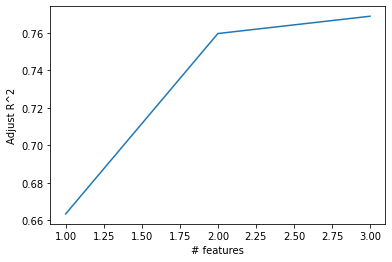

In [44]:
"""
The following graph shows the adj R^2 is still increasing, 
in this case, it is a good idea trying models with more features. 
"""
plt.figure()
plt.plot(rsquared_adj)
plt.xlabel('# features')
plt.ylabel('Adjust R^2')
plt.show()

## 6.5.2 Forward and Backward Stepwise Selection

In [48]:
"""
We can use the previous user defined function 'def getRSS(y, X, feature_list)' to add 1 feature at a time (start from 0 feature) for forward stepwise selection
or delete 1 feature at a time(start from all the features) for backward stepwise selection. 
"""
def forward_select(y, X, feature_list):
    remaining_predictors = [p for p in X.columns if p not in feature_list]
    results = []
    for p in remaining_predictors:
        results.append(getRSS(y, X, feature_list+[p]))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model  

In [49]:
models2 = pd.DataFrame(columns=["RSS", "Model"])
feature_list = []
for i in range(1,len(X.columns)+1):
    models2.loc[i] = forward_select(y, X, feature_list)
    feature_list = models2.loc[i]["Model"].model.exog_names

In [50]:
"""we can compare the results of best subset selection and the forward selection"""
print('Best max_feature variable from best subset selection on tranining')
print(models.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best max_feature variable from forward selection on tranining')
print(models2.loc[max_feature, 'Model'].params)

Best max_feature variable from best subset selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64

---------------------------------------------
Best max_feature variable from forward selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64


In [60]:
rsquared_adj = models2.apply(lambda a: 
                            a[1].rsquared_adj, axis=1)
# find the adjust R^2, use dir() to identify all available attributes
print(models2,rsquared_adj)
# R^2 increasing & RSS lowering but adj R^2 is falling post 10 p hence, we dont need more than 10 p, others are insignificant

             RSS                                              Model
1   4.321393e+07  <statsmodels.regression.linear_model.Regressio...
2   3.073305e+07  <statsmodels.regression.linear_model.Regressio...
3   2.943854e+07  <statsmodels.regression.linear_model.Regressio...
4   2.826074e+07  <statsmodels.regression.linear_model.Regressio...
5   2.717538e+07  <statsmodels.regression.linear_model.Regressio...
6   2.621956e+07  <statsmodels.regression.linear_model.Regressio...
7   2.596156e+07  <statsmodels.regression.linear_model.Regressio...
8   2.516030e+07  <statsmodels.regression.linear_model.Regressio...
9   2.483520e+07  <statsmodels.regression.linear_model.Regressio...
10  2.455470e+07  <statsmodels.regression.linear_model.Regressio...
11  2.446856e+07  <statsmodels.regression.linear_model.Regressio...
12  2.441054e+07  <statsmodels.regression.linear_model.Regressio...
13  2.438377e+07  <statsmodels.regression.linear_model.Regressio...
14  2.435901e+07  <statsmodels.regression.linear

In [57]:
models2.iloc[18,1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Salary   R-squared (uncentered):                   0.811
Model:                            OLS   Adj. R-squared (uncentered):              0.797
Method:                 Least Squares   F-statistic:                              55.27
Date:                Sun, 13 Sep 2020   Prob (F-statistic):                    4.31e-77
Time:                        00:37:30   Log-Likelihood:                         -1876.7
No. Observations:                 263   AIC:                                      3791.
Df Residuals:                     244   BIC:                                      3859.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Hits            7.1911      2.356      3.052      0.003       2.550      11.832
CRBI            0.7872      0.692      1.137      0.257      -0.576       2.151
PutOuts         0.2850      0.077      3.684      0.000       0.133       0.437
AtBat          -1.7313      0.580     -2.983      0.003      -2.875      -0.588
Division_E    125.2451     39.435      3.176      0.002      47.569     202.921
Walks           6.3288      1.826      3.467      0.001       2.733       9.925
CWalks         -0.7956      0.328     -2.428      0.016      -1.441      -0.150
CRuns           1.4150      0.749      1.888      0.060      -0.061       2.891
CAtBat         -0.1848      0.135     -1.374      0.171      -0.450       0.080
Assists         0.3295      0.217      1.518      0.130      -0.098       0.757
Runs           -2.5588      2.975     -0.860      0.391      -8.418       3.300
League_A      -65.2984     79.205     -0.824      0.411    -221.312      90.715
HmRun           4.3739      6.201      0.705      0.481      -7.840      16.588
Errors         -2.4430      4.289     -0.570      0.570     -10.892       6.006
NewLeague_A    35.2820     78.255      0.451      0.652    -118.860     189.424
RBI            -1.2435      2.593     -0.480      0.632      -6.350       3.863
CHits           0.1650      0.674      0.245      0.807      -1.162       1.492
Years           2.7882     10.613      0.263      0.793     -18.117      23.693
CHmRun         -0.1630      1.617     -0.101      0.920      -3.348       3.022
==============================================================================
Omnibus:                       93.665   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              548.775
Skew:                           1.295   Prob(JB):                    6.84e-120
Kurtosis:                       9.585   Cond. No.                     2.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [64]:
def backward_select(y, X, feature_list):
    results = []
    for combo in itertools.combinations(feature_list, len(feature_list)-1):
        results.append(getRSS(y, X, combo))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model 

In [65]:
"""
The backward selection starts from all the variables of features
"""
models3 = pd.DataFrame(columns=["RSS", "Model"], index = range(1,len(X.columns)))
feature_list = X.columns

while(len(feature_list) > 1):
    models3.loc[len(feature_list)-1] = backward_select(y, X, feature_list)
    feature_list = models3.loc[len(feature_list)-1]["Model"].model.exog_names

print(models3.loc[max_feature, "Model"].params)

Hits       2.111712
CRuns      0.646149
PutOuts    0.295625
dtype: float64


In [66]:
rsquared_adj = models3.apply(lambda a: 
                            a[1].rsquared_adj, axis=1)
# find the adjust R^2, use dir() to identify all available attributes
print(models3,rsquared_adj)
# R^2 increasing & RSS lowering but adj R^2 is falling post 10 p hence, we dont need more than 10 p, others are insignificant

            RSS                                              Model
1   4.32139e+07  <statsmodels.regression.linear_model.Regressio...
2   3.13002e+07  <statsmodels.regression.linear_model.Regressio...
3   2.96395e+07  <statsmodels.regression.linear_model.Regressio...
4   2.84592e+07  <statsmodels.regression.linear_model.Regressio...
5   2.75168e+07  <statsmodels.regression.linear_model.Regressio...
6   2.67055e+07  <statsmodels.regression.linear_model.Regressio...
7   2.59362e+07  <statsmodels.regression.linear_model.Regressio...
8   2.51603e+07  <statsmodels.regression.linear_model.Regressio...
9   2.48352e+07  <statsmodels.regression.linear_model.Regressio...
10  2.45547e+07  <statsmodels.regression.linear_model.Regressio...
11  2.44686e+07  <statsmodels.regression.linear_model.Regressio...
12  2.44105e+07  <statsmodels.regression.linear_model.Regressio...
13  2.43838e+07  <statsmodels.regression.linear_model.Regressio...
14   2.4359e+07  <statsmodels.regression.linear_model.Regressi

## 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation

In [68]:
# Randomly split the data into traning dataset and validation dateset
np.random.seed(seed = 21)
train_index = np.random.choice([True, False], size = len(y), replace = True, p = [0.7, 0.3]) 
# random select ~70% of data into traning sample
# the rest of the samples will be in testing set
test_index = np.invert(train_index)
X_train= X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]

In [75]:
""" We can recyle the old functions. Modification is needed to compute the RSS for the testing data. 
So we need to add both train and test into the function input (Implement)
-OR-: we can wrap the train and test split step into the function(Not Implemented)
"""
def getRSS_validation(y_train, X_train, y_test, X_test,  feature_list):
    model = sm.OLS(y_train, X_train[list(feature_list)]).fit()
    RSS = ((model.predict(X_test[list(feature_list)]) - y_test) ** 2).sum()
    return {'Model':model, "RSS":RSS}

def bestModel_validation(y_train, X_train, y_test, X_test, K):
    results = []
    for c in itertools.combinations(X_train.columns, K):
        results.append(getRSS_validation(y_train, X_train, y_test, X_test, c))     
    model_all =  pd.DataFrame(results)
    
    best_model = model_all.loc[model_all["RSS"].idxmin()] ## this could be modified to have the top several models
    return best_model


def forward_select_validation(y_train, X_train, y_test, X_test,  feature_list):
    remaining_predictors = [p for p in X_train.columns if p not in feature_list]
    results = []
    for p in remaining_predictors:
        results.append(getRSS_validation(y_train, X_train, y_test, X_test, feature_list+[p]))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model

def backward_select_validation(y_train, X_train, y_test, X_test,  feature_list):
    results = []
    for combo in itertools.combinations(feature_list, len(feature_list)-1):
        results.append(getRSS_validation(y_train, X_train, y_test, X_test,  combo))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model  

In [76]:
models_validation = pd.DataFrame(columns=["RSS", "Model"])
for i in range(1,(max_feature+1)):  # for illustration purpuse, I just run for 1 - max_fearure features 
    models_validation.loc[i] = bestModel_validation(y_train, X_train, y_test, X_test, i) 
    
    
"""change the function to  forward_select_validation (.) or backward_select_validation(.) 
for forward selection or backward selection""" 
    
models2_forward = pd.DataFrame(columns=["RSS", "Model"])
feature_list = []
for i in range(1,len(X.columns)+1):
    models2_forward.loc[i] = forward_select_validation(y_train, X_train, y_test, X_test,  feature_list)
    feature_list = models2_forward.loc[i]["Model"].model.exog_names    



In [77]:
print('Best max_feature variable from best subset selection on training')
print(models.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best max_feature variable from forward selection on training')
print(models2.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best max_feature variable from backward selection on training')
print(models3.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best max_feature variable from best subset selection on training and validation split')
print(models_validation.loc[max_feature, 'Model'].params)

Best max_feature variable from best subset selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64

---------------------------------------------
Best max_feature variable from forward selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64

---------------------------------------------
Best max_feature variable from backward selection on tranining
Hits       2.111712
CRuns      0.646149
PutOuts    0.295625
dtype: float64

---------------------------------------------
Best max_feature variable from best subset selection on traning and validation split
Hits       2.591880
CHmRun     2.675775
PutOuts    0.210471
dtype: float64


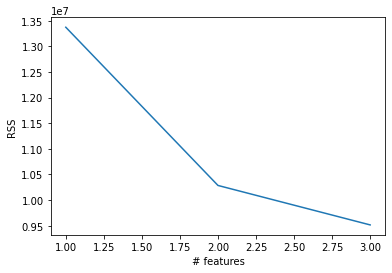

In [78]:
""" this show an example to plot the RSS of best models with different number of parameters for best subset with validation"""
plt.figure()
plt.plot(models_validation["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

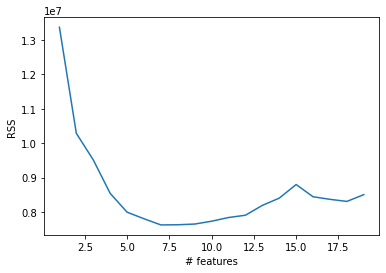

' From above graph, that 6 variables model gives us the best RSS under forward selection. \nTo learn the final model, it is also recommendated to re-train the model on entire data (train + validation). '

In [83]:
""" this show an example to plot the RSS of best models with different number of parameters for forward selection with validation"""
plt.figure()
plt.plot(models2_forward["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()
""" From above graph, that 6 variables model gives us the best RSS under forward selection. 
To learn the final model, it is also recommendated to re-train the model on entire data (train + validation). """

            RSS                                              Model
1   4.32139e+07  <statsmodels.regression.linear_model.Regressio...
2   3.13002e+07  <statsmodels.regression.linear_model.Regressio...
3   2.96395e+07  <statsmodels.regression.linear_model.Regressio...
4   2.84592e+07  <statsmodels.regression.linear_model.Regressio...
5   2.75168e+07  <statsmodels.regression.linear_model.Regressio...
6   2.67055e+07  <statsmodels.regression.linear_model.Regressio...
7   2.59362e+07  <statsmodels.regression.linear_model.Regressio...
8   2.51603e+07  <statsmodels.regression.linear_model.Regressio...
9   2.48352e+07  <statsmodels.regression.linear_model.Regressio...
10  2.45547e+07  <statsmodels.regression.linear_model.Regressio...
11  2.44686e+07  <statsmodels.regression.linear_model.Regressio...
12  2.44105e+07  <statsmodels.regression.linear_model.Regressio...
13  2.43838e+07  <statsmodels.regression.linear_model.Regressio...
14   2.4359e+07  <statsmodels.regression.linear_model.Regressi

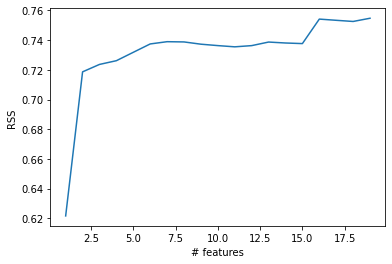

' From above graph, that 6 variables model gives us the best RSS under forward selection. \nTo learn the final model, it is also recommendated to re-train the model on entire data (train + validation). '

In [84]:
rsquared_adj = models2_forward.apply(lambda a: 
                            a[1].rsquared_adj, axis=1)
# find the adjust R^2, use dir() to identify all available attributes
print(models3,rsquared_adj)
""" this show an example to plot the RSS of best models with different number of parameters for forward selection with validation"""
plt.figure()
plt.plot(rsquared_adj)
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()
""" From above graph, that 6 variables model gives us the best RSS under forward selection. 
To learn the final model, it is also recommendated to re-train the model on entire data (train + validation). """
# R^2 increasing & RSS lowering but adj R^2 is falling post 10 p hence, we dont need more than 10 p, others are insignificant

### Cross-Validation

In [85]:
"""This approach is similar to the previous validation idea. 
The difference is that we break the entire dataset into K different folds. 
Each run, the model will be trained on all the data from K-1 folds and tested on the remaining fold.
Advantages: 
1. There will be multiple metrics out of testing results => distribution of testing RSS, etc
2. The size of traning dataset is much closer to the size of original dateset. This will remove some biases caused by
the size difference."""

k = 10
np.random.seed(seed = 21)
train_index = np.random.choice(k, size = len(y), replace = True)  # Randomly assign each observations into folds
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,len(X.columns) + 1))

In [86]:
models_cv = pd.DataFrame(columns=["RSS", "Model"])
for j in range(1,k+1):
    feature_list = []
    for i in range(1,len(X.columns)+1):
        models_cv.loc[i] = forward_select_validation(y[train_index!= (j-1)], X[train_index != (j-1)], 
                                                     y[train_index == (j-1)],X[train_index == (j-1)], 
                                                     feature_list)
        
        cv_errors[j][i] = models_cv.loc[i]["RSS"]
        feature_list = models_cv.loc[i]["Model"].model.exog_names

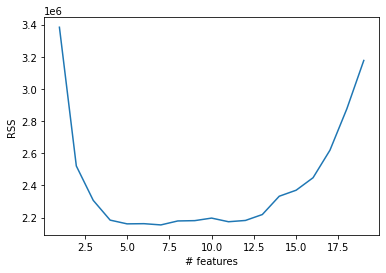

In [87]:
cv_errors_mean = cv_errors.mean(axis = 1)
plt.figure()
plt.plot(cv_errors_mean)
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

In [88]:
"""From the above plot, we can see that the model with 5 variables yielded the smallest RSS.
We can take a closer look at that model summary. 
We can also see that the model performance for variables 4 - 12 are similar."""
print(models_cv.loc[5, "Model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.771
Model:                            OLS   Adj. R-squared (uncentered):              0.766
Method:                 Least Squares   F-statistic:                              155.0
Date:                Sun, 13 Sep 2020   Prob (F-statistic):                    1.40e-71
Time:                        03:36:47   Log-Likelihood:                         -1704.1
No. Observations:                 235   AIC:                                      3418.
Df Residuals:                     230   BIC:                                      3435.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# 6.6 Lab 2: Ridge Regression and the Lasso

### sklearn has the ridge and lasso functionality implemented. So here we import those submodules 

In [90]:
from sklearn.preprocessing import scale 
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

In [94]:
Hitters = pd.read_csv('/Users/shilpa/Documents/blog/Sharing_ISL_python/data/Hitters.csv', header=0, na_values='NA')
Hitters = Hitters.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])

y = Hitters.Salary  # the response variable 
X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)

In [99]:
alphas = 10**np.linspace(10,-2,100)
np.linspace?
alphas

array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+07, 2.84803587e+07, 2.15443469e+07, 1.62975083e+07,
       1.23284674e+07, 9.32603347e+06, 7.05480231e+06, 5.33669923e+06,
       4.03701726e+06, 3.05385551e+06, 2.31012970e+06, 1.74752840e+06,
       1.32194115e+06, 1.00000000e+06, 7.56463328e+05, 5.72236766e+05,
       4.32876128e+05, 3.27454916e+05, 2.47707636e+05, 1.87381742e+05,
       1.41747416e+05, 1.07226722e+05, 8.11130831e+04, 6.13590727e+04,
       4.64158883e+04, 3.51119173e+04, 2.65608778e+04, 2.00923300e+04,
       1.51991108e+04, 1.14975700e+04, 8.69749003e+03, 6.57933225e+03,
       4.97702356e+03, 3.76493581e+03, 2.84803587e+03, 2.15443469e+03,
      

In [100]:
ridge = Ridge(fit_intercept=True, normalize=True)
coeffs = []
intercepts = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X, y)
    coeffs.append(ridge.coef_)
    intercepts.append(ridge.intercept_)

In [102]:
print(len(coeffs))
print(len(coeffs[0]))
print(len(intercepts))
print(intercepts[0]) # try run print len(intercepts[0])

100
19
100
535.9258816915063


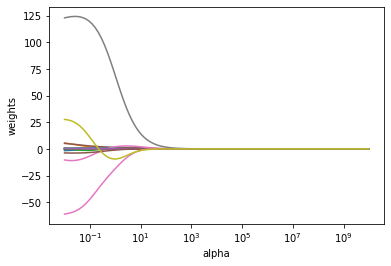

In [103]:
ax = plt.gca()
ax.plot(alphas, coeffs)
ax.set_xscale('log') # try without this line
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

In [2]:
X_train, X_test , y_train, y_test = cross_validate(X, y)

NameError: name 'cross_validate' is not defined

## X_train, X_test , y_train, y_test = cross_validate.train_test_split(X, y, test_size=0.66)

In [ ]:
ridge = Ridge(fit_intercept=True, normalize=True, alpha=4)
ridge.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge.coef_, index=X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))        # Calculate the test MSE

## 6.7.1 Principal Components Regression

In [110]:
Hitters = pd.read_csv('/Users/shilpa/Documents/blog/Sharing_ISL_python/data/Hitters.csv', header=0, na_values='NA')
Hitters = Hitters.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
y = Hitters.Salary  # the response variable 
dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])
X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)

In [115]:
pca = PCA()
X_pca = pca.fit_transform(scale(X))
regr = linear_model.LinearRegression()
X_pca

NameError: name 'pc' is not defined

In [116]:
def pcr(X,y,pc):
    ''' Principal Component Regression in Python'''
    ''' Step 1: PCA on input data'''

    # Define the PCA object
    pca = PCA()

    # Preprocessing (1): first derivative
    X_pca = pca.fit_transform(scale(X))[:,:pc]

    ''' Step 2: regression on selected principal components'''

    # Create linear regression object
    regr = linear_model.LinearRegression()
    
    # Fit
    regr.fit(X_pca, y)

    # Calibration
    y_train = regr.predict(X_pca)

    # Cross-validation
    y_cv = cross_val_predict(regr, X_pca, y, cv=20)

    # Calculate scores for training and cross-validation
    score_train = r2_score(y, y_train)
    score_cv = r2_score(y, y_cv)

    # Calculate mean square error for training and cross validation
    mse_train = mean_squared_error(y, y_train)
    mse_cv = mean_squared_error(y, y_cv)

    return(y_cv, score_train, score_cv, mse_train, mse_cv)



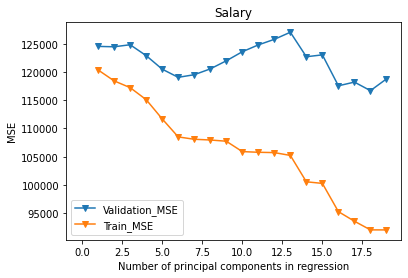

In [117]:
mse_train = []
mse_cv = []

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    results =  pcr(X,y,i)
    mse_train.append(results[3])
    mse_cv.append(results[4])
    
# Plot results    
plt.plot(np.arange(1, 20), mse_cv, '-v', label = 'Validation_MSE')
plt.plot(np.arange(1, 20), mse_train, '-v', label = 'Train_MSE')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)
plt.legend()
plt.show()

In [119]:

pca2 = PCA()
# Scale the data
X_reduced_train = pca2.fit_transform(scale(X_train))
X_reduced_test = pca2.transform(scale(X_test))[:,:6]
# Train regression model on training data 
regr = linear_model.LinearRegression()
regr.fit(X_reduced_train[:,:6], y_train)
# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

116185.41827718385

In [120]:
np.cumsum(pca.explained_variance_ratio_) * 100

array([ 38.31423957,  60.15531541,  70.8416746 ,  79.03419435,
        84.29027516,  88.63477938,  92.26288766,  94.96304322,
        96.28269124,  97.25541298,  97.97775424,  98.64870031,
        99.15178693,  99.4730334 ,  99.74659124,  99.89398793,
        99.96815949,  99.99375108, 100.        ])